# 06wk-2: 딥러닝의 기초 (7)

최규빈  
2022-10-11

> 깊은신경망(3)– 신경망의표현, 시벤코정리증명, CPU vs GPU,
> 확률적경사하강법(+배치,에폭의 개념), 오버피팅

# 강의영상

> <https://youtube.com/playlist?list=PLQqh36zP38-zXzWcQw8KYaSDuBOrEp7AA>

# imports

In [1]:
import torch
import torchvision
from fastai.data.all import *

In [2]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+s + '; }');

# 신경망의 표현 (${\boldsymbol x} \to \hat{\boldsymbol y}$ 로 가는 과정을 그림으로 표현)

## 예제1: $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(1)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(1)}} =\underset{(n,1)}{\hat{\boldsymbol y}}$

`-` 모든 observation과 가중치를 명시한 버전

**(표현1)**

In [3]:
gv(''' 
    "1" -> "ŵ₀ + xₙ*ŵ₁,    bias=False"[label="* ŵ₀"]
    "xₙ" -> "ŵ₀ + xₙ*ŵ₁,    bias=False"[label="* ŵ₁"]
    "ŵ₀ + xₙ*ŵ₁,    bias=False" -> "ŷₙ"[label="sigmoid"]

    "." -> "...................................."[label="* ŵ₀"]
    ".." -> "...................................."[label="* ŵ₁"]
    "...................................." -> "..."[label=" "]

    "1 " -> "ŵ₀ + x₂*ŵ₁,    bias=False"[label="* ŵ₀"]
    "x₂" -> "ŵ₀ + x₂*ŵ₁,    bias=False"[label="* ŵ₁"]
    "ŵ₀ + x₂*ŵ₁,    bias=False" -> "ŷ₂"[label="sigmoid"]
    
    "1  " -> "ŵ₀ + x₁*ŵ₁,    bias=False"[label="* ŵ₀"]
    "x₁" -> "ŵ₀ + x₁*ŵ₁,    bias=False"[label="* ŵ₁"]
    "ŵ₀ + x₁*ŵ₁,    bias=False" -> "ŷ₁"[label="sigmoid"]
''')

-   단점: 똑같은 그림의 반복이 너무 많음

`-` observation 반복을 생략한 버전들

**(표현2)** 모든 $i$에 대하여 아래의 그림을 반복한다고 하면 (표현1)과
같다.

In [4]:
gv(''' 
    "1" -> "ŵ₀ + xᵢ*ŵ₁,    bias=False"[label="* ŵ₀"]
    "xᵢ" -> "ŵ₀ + xᵢ*ŵ₁,    bias=False"[label="* ŵ₁"]
    "ŵ₀ + xᵢ*ŵ₁,    bias=False" -> "ŷᵢ"[label="sigmoid"]

''')


**(표현3)** 그런데 (표현2)에서 아래와 같이 $x_i$, $y_i$ 대신에 간단히
$x$, $y$로 쓰는 경우도 많음

In [5]:
gv(''' 
    "1" -> "ŵ₀ + x*ŵ₁,    bias=False"[label="* ŵ₀"]
    "x" -> "ŵ₀ + x*ŵ₁,    bias=False"[label="* ŵ₁"]
    "ŵ₀ + x*ŵ₁,    bias=False" -> "ŷ"[label="sigmoid"]

''')


`-` 1을 생략한 버전들

**(표현4)** bais=False 대신에 bias=True를 주면 1을 생략할 수 있음

In [6]:
gv('''
"x" -> "x*ŵ₁,    bias=True"[label="*ŵ₁"] ;
"x*ŵ₁,    bias=True" -> "ŷ"[label="sigmoid"] ''')


**(표현4의 수정)** $\hat{w}_1$대신에 $\hat{w}$를 쓰는 것이 더 자연스러움

In [7]:
gv('''
"x" -> "x*ŵ,    bias=True"[label="*ŵ"] ;
"x*ŵ,    bias=True" -> "ŷ"[label="sigmoid"] ''')


**(표현5)** 선형변환의 결과는 아래와 같이 $u$로 표현하기도 한다.

In [8]:
gv('''
"x" -> "u";
"u" -> "y"[label="sigmoid"] ''')


> 다이어그램은 그리는 사람의 취향에 따라 그리는 방법이 조금씩 다릅니다.
> 즉 교재마다 달라요.

## 예제2: $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}} =\underset{(n,1)}{\hat{\boldsymbol y}}$

**참고: 코드로 표현**

``` python
torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=2),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2,out_features=1),
    torch.nn.Sigmoid()
)
```

`-` 이해를 위해서 10월4일 강의노트에서 다루었던 아래의 상황을 고려하자.

![](https://guebin.github.io/DL2022/posts/II.%20DNN/2022-10-04-5wk-2_files/figure-html/cell-20-output-1.png)

**(강의노트의 표현)**

In [9]:
gv('''
"x" -> " -x"[label="*(-1)"];
"x" -> " x"[label="*1"]
" x" -> "rlu(x)"[label="relu"] 
" -x" -> "rlu(-x)"[label="relu"] 
"rlu(x)" -> "u"[label="*(-4.5)"] 
"rlu(-x)" -> "u"[label="*(-9.0)"] 
"u" -> "sig(u)=yhat"[label="sig"] 
'''
)

**(좀 더 일반화된 표현)** 10월4일 강의노트 상황을 일반화하면 아래와
같다.

In [10]:
gv('''
"x" -> "u1[:,0]"[label="*(-1)"];
"x" -> "u1[:,1]"[label="*1"]
"u1[:,0]" -> "v1[:,0]"[label="relu"] 
"u1[:,1]" -> "v1[:,1]"[label="relu"] 
"v1[:,0]" -> "u2"[label="*(-9.0)"] 
"v1[:,1]" -> "u2"[label="*(-4.5)"] 
"u2" -> "v2=yhat"[label="sig"] 
'''
)

`*` Layer의 개념: ${\bf X}$에서 $\hat{\boldsymbol y}$로 가는 과정은
“선형변환+비선형변환”이 반복되는 구조이다. “선형변환+비선형변환”을
하나의 세트로 보면 아래와 같이 표현할 수 있다.

$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \left( \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \right) \overset{l_2}{\to} \left(\underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}\right), \quad \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{net({\bf X})}=\underset{(n,1)}{\hat{\boldsymbol y}}$

이것을 다이어그램으로 표현한다면 아래와 같다.

**(선형+비선형을 하나의 Layer로 묶은 표현)**

In [11]:
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "X" 
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "X" -> "u1[:,0]"
    "X" -> "u1[:,1]"
    "u1[:,0]" -> "v1[:,0]"[label="relu"]
    "u1[:,1]" -> "v1[:,1]"[label="relu"]
    label = "Layer 1"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "v1[:,0]" -> "u2"
    "v1[:,1]" -> "u2"
    "u2" -> "v2=yhat"[label="sigmoid"]
    label = "Layer 2"
}
''')

***Layer를 세는 방법***

-   정석: 학습가능한 파라메터가 몇층으로 있는지…
-   일부 교재 설명: 입력층은 계산하지 않음, activation layer는 계산하지
    않음.
-   위의 예제의 경우 `number of layer = 2` 이다.

> 사실 input layer, activation layer 등의 표현을 자주 사용해서 layer를
> 세는 방법이 처음에는 헷갈립니다..

***Hidden Layer의 수를 세는 방법***

-   `Layer의 수 = Hidden Layer의 수 + 출력층의 수 = Hidden Layer의 수 + 1`
-   위의 예제의 경우 `number of hidden layer = 1` 이다.

`*` node의 개념: $u\to v$로 가는 쌍을 간단히 노드라는 개념을 이용하여
나타낼 수 있음.

**(노드의 개념이 포함된 그림)**

In [12]:
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "X" 
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "X" -> "node1"
    "X" -> "node2"
    label = "Layer 1:relu"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "yhat "
    "node2" -> "yhat "
    label = "Layer 2:sigmoid"
}
''')

여기에서 `node의 숫자 = feature의 숫자`와 같이 이해할 수 있다. 즉 아래와
같이 이해할 수 있다.

**(“number of nodes = number of features”로 이해한 그림)**

In [13]:
gv('''
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "X" 
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "X" -> "feature1"
    "X" -> "feature2"
    label = "Layer 1:relu"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "feature1" -> "yhat "
    "feature2" -> "yhat "
    label = "Layer 2:sigmoid"
}
''')

> 다이어그램의 표현방식은 교재마다 달라서 모든 예시를 달달 외울 필요는
> 없습니다. 다만 임의의 다이어그램을 보고 대응하는 네트워크를 pytorch로
> 구현하는 능력은 매우 중요합니다.

## 예제3: $\underset{(n,784)}{\bf X} \overset{l_1}{\to} \underset{(n,32)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,32)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{sig}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

**(다이어그램표현)**

In [14]:
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x1"
    "x2"
    ".."
    "x784"
    label = "Input Layer"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x1" -> "node1"
    "x2" -> "node1"
    ".." -> "node1"
    
    "x784" -> "node1"
    "x1" -> "node2"
    "x2" -> "node2"
    ".." -> "node2"
    "x784" -> "node2"
    
    "x1" -> "..."
    "x2" -> "..."
    ".." -> "..."
    "x784" -> "..."

    "x1" -> "node32"
    "x2" -> "node32"
    ".." -> "node32"
    "x784" -> "node32"


    label = "Hidden Layer: relu"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;

    "node1" -> "yhat"
    "node2" -> "yhat"
    "..." -> "yhat"
    "node32" -> "yhat"
    
    label = "Outplut Layer: sigmoid"
}
''')

-   Layer0,1,2 대신에 Input Layer, Hidden Layer, Output Layer로 표현함

`-` 위의 다이어그램에 대응하는 코드

``` python
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=28*28*1,out_features=32),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=32,out_features=1),
    torch.nn.Sigmoid() 
)
```

# 시벤코정리가 성립하는 이유? (엄밀한 증명 X)

## 그림으로 보는 증명과정

`-` 데이터

In [15]:
x = torch.linspace(-10,10,200).reshape(-1,1)

`-` 아래와 같은 네트워크를 고려하자.

In [16]:
l1 = torch.nn.Linear(in_features=1,out_features=2)
a1 = torch.nn.Sigmoid()
l2 = torch.nn.Linear(in_features=2,out_features=1)

`-` 직관1: $l_1$,$l_2$의 가중치를 잘 결합하다보면 우연히 아래와 같이
만들 수 있다.

In [17]:
l1.weight.data = torch.tensor([[-5.00],[5.00]])
l1.bias.data = torch.tensor([+10.00,+10.00])

In [18]:
l2.weight.data = torch.tensor([[1.00,1.00]])
l2.bias.data = torch.tensor([-1.00])

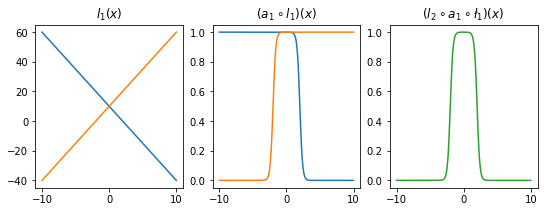

In [19]:
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].plot(x,l1(x).data); ax[0].set_title('$l_1(x)$')
ax[1].plot(x,a1(l1(x)).data); ax[1].set_title('$(a_1 \circ l_1)(x)$')
ax[2].plot(x,l2(a1(l1(x))).data,color='C2'); ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$')

`-` 직관2: 아래들도 가능할듯?

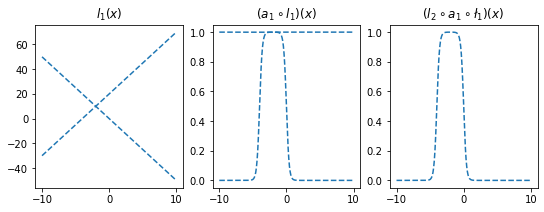

In [20]:
l1.weight.data = torch.tensor([[-5.00],[5.00]])
l1.bias.data = torch.tensor([+0.00,+20.00])
l2.weight.data = torch.tensor([[1.00,1.00]])
l2.bias.data = torch.tensor([-1.00])
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].plot(x,l1(x).data,'--',color='C0'); ax[0].set_title('$l_1(x)$')
ax[1].plot(x,a1(l1(x)).data,'--',color='C0'); ax[1].set_title('$(a_1 \circ l_1)(x)$')
ax[2].plot(x,l2(a1(l1(x))).data,'--',color='C0'); ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$');

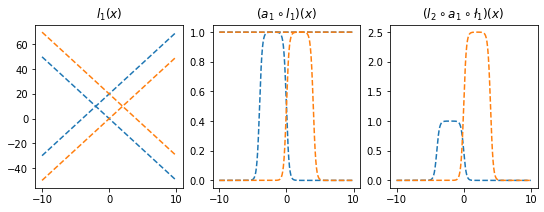

In [21]:
l1.weight.data = torch.tensor([[-5.00],[5.00]])
l1.bias.data = torch.tensor([+20.00,+0.00])
l2.weight.data = torch.tensor([[2.50,2.50]])
l2.bias.data = torch.tensor([-2.50])
ax[0].plot(x,l1(x).data,'--',color='C1'); ax[0].set_title('$l_1(x)$')
ax[1].plot(x,a1(l1(x)).data,'--',color='C1'); ax[1].set_title('$(a_1 \circ l_1)(x)$')
ax[2].plot(x,l2(a1(l1(x))).data,'--',color='C1'); ax[2].set_title('$(l_2 \circ a_1 \circ \l_1)(x)$');
fig

`-` `은닉층의노드수=4`로 하고 적당한 가중치를 조정하면
$(l_2\circ a_1 \circ l_1)(x)$의 결과로 주황색선 + 파란색선도 가능할 것
같다. $\to$ 실제로 가능함

In [22]:
l1 = torch.nn.Linear(in_features=1,out_features=4)
a1 = torch.nn.Sigmoid()
l2 = torch.nn.Linear(in_features=4,out_features=1)

In [23]:
l1.weight.data = torch.tensor([[-5.00],[5.00],[-5.00],[5.00]])
l1.bias.data = torch.tensor([0.00, 20.00, 20.00, 0])
l2.weight.data = torch.tensor([[1.00,  1.00, 2.50,  2.50]])
l2.bias.data = torch.tensor([-1.0-2.5])

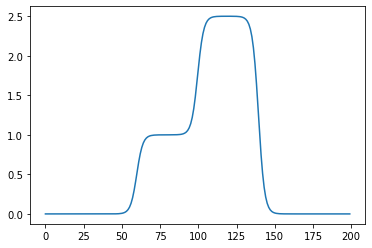

In [24]:
plt.plot(l2(a1(l1(x))).data)

`-` 2개의 시그모이드를 우연히 잘 결합하면 아래와 같은 함수 $h$를 만들 수
있다.

In [25]:
h = lambda x: torch.sigmoid(200*(x+0.5))+torch.sigmoid(-200*(x-0.5))-1.0

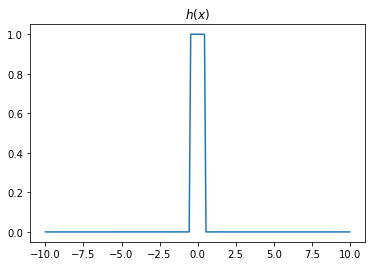

In [26]:
plt.plot(x,h(x))
plt.title("$h(x)$")

`-` 위와 같은 함수 $h$를 활성화함수로 하고 $m$개의 노드를 가지는
은닉층을 생각해보자. 이러한 은닉층을 사용한다면 전체 네트워크를 아래와
같이 표현할 수 있다.

$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{h}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$

그리고 위의 네트워크와 동일한 효과를 주는 아래의 네트워크가 항상 존재함.

$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2m)}{\boldsymbol u^{(1)}} \overset{sig}{\to} \underset{(n,2m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$

`-` $h(x)$를 활성화함수로 가지는 네트워크를 설계하여 보자.

In [27]:
class MyActivation(torch.nn.Module): ## 사용자정의 활성화함수를 선언하는 방법
    def __init__(self):
        super().__init__() 
    def forward(self, input):
        return h(input) # activation 의 출력 

In [28]:
a1=MyActivation()
# a1 = torch.nn.Sigmoid(), a1 = torch.nn.ReLU() 대신에 a1 = MyActivation()

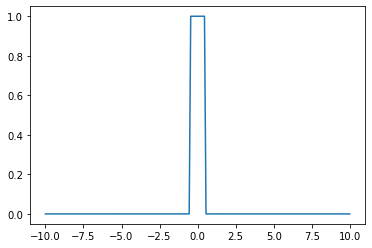

In [29]:
plt.plot(x,a1(x)) 

**히든레이어가 1개의 노드를 가지는 경우**

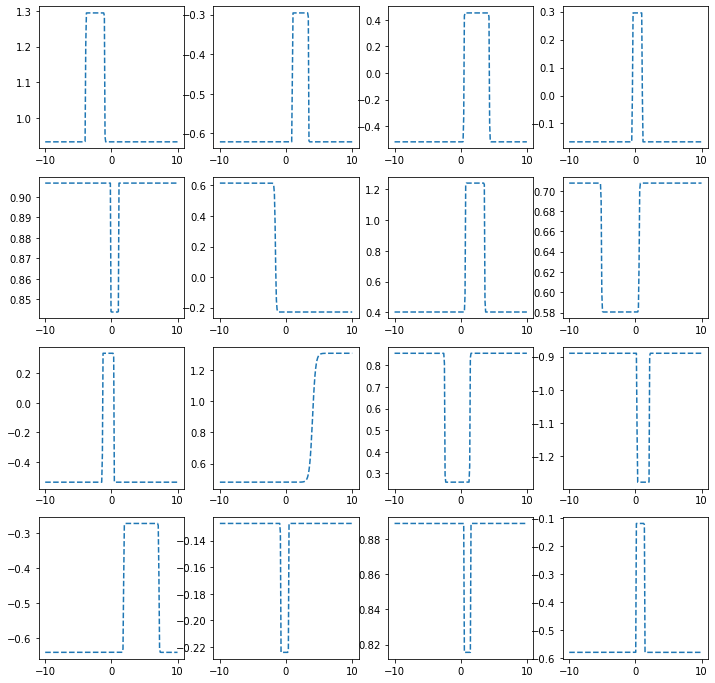

In [30]:
torch.manual_seed(43052)
fig, ax = plt.subplots(4,4,figsize=(12,12))
for i in range(4):
    for j in range(4):
        net = torch.nn.Sequential(
            torch.nn.Linear(1,1),
            MyActivation(),
            torch.nn.Linear(1,1)
        )
        ax[i,j].plot(x,net(x).data,'--')

**히든레이어가 2개의 노드를 가지는 경우**

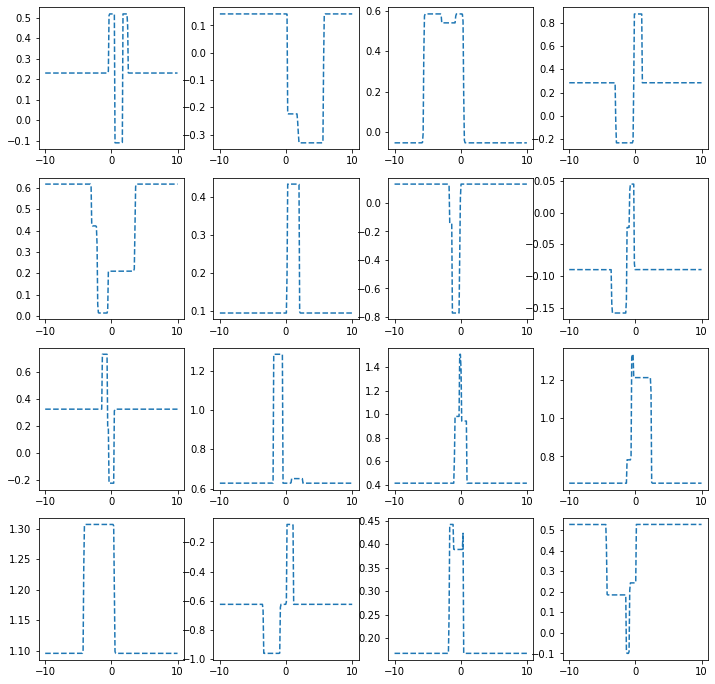

In [31]:
torch.manual_seed(43052)
fig, ax = plt.subplots(4,4,figsize=(12,12))
for i in range(4):
    for j in range(4):
        net = torch.nn.Sequential(
            torch.nn.Linear(1,2),
            MyActivation(),
            torch.nn.Linear(2,1)
        )
        ax[i,j].plot(x,net(x).data,'--')

**히든레이어가 3개의 노드를 가지는 경우**

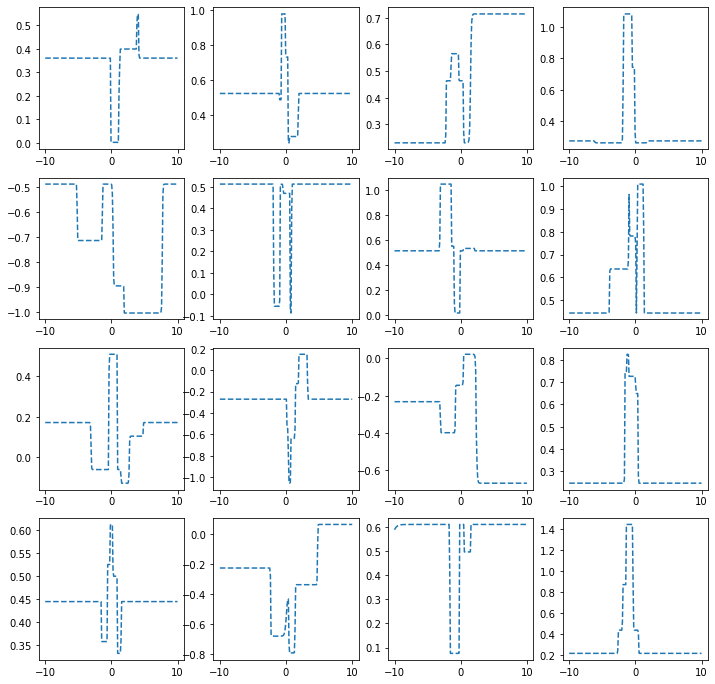

In [32]:
torch.manual_seed(43052)
fig, ax = plt.subplots(4,4,figsize=(12,12))
for i in range(4):
    for j in range(4):
        net = torch.nn.Sequential(
            torch.nn.Linear(1,3),
            MyActivation(),
            torch.nn.Linear(3,1)
        )
        ax[i,j].plot(x,net(x).data,'--')

**히든레이어가 1024개의 노드를 가지는 경우**

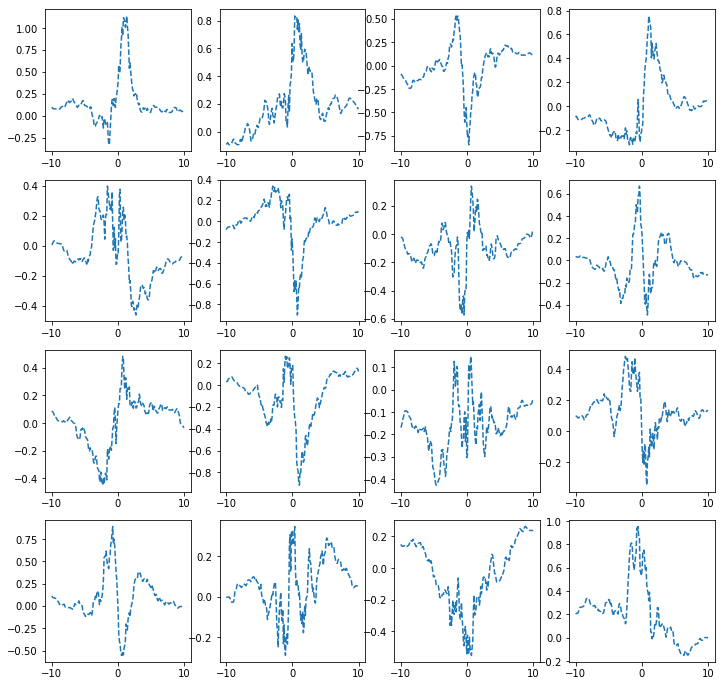

In [33]:
torch.manual_seed(43052)
fig, ax = plt.subplots(4,4,figsize=(12,12))
for i in range(4):
    for j in range(4):
        net = torch.nn.Sequential(
            torch.nn.Linear(1,1024),
            MyActivation(),
            torch.nn.Linear(1024,1)
        )
        ax[i,j].plot(x,net(x).data,'--')

## 하나의 은닉층에 많은 노드수가 있는 신경망

`-` 아래와 같이 하나의 은닉층을 가지고 있더라도 많은 노드수만 보장되면
매우 충분한 표현력을 가짐

$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{h}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$

(예시1)

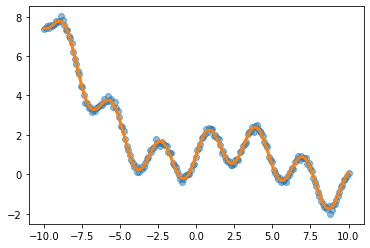

In [59]:
torch.manual_seed(43052)
x = torch.linspace(-10,10,200).reshape(-1,1)
underlying = torch.sin(2*x) + torch.sin(0.5*x) + torch.exp(-0.2*x)
eps = torch.randn(200).reshape(-1,1)*0.1
y = underlying + eps 
plt.plot(x,y,'o',alpha=0.5)
plt.plot(x,underlying,lw=3)

In [60]:
h = lambda x: torch.sigmoid(200*(x+0.5))+torch.sigmoid(-200*(x-0.5))-1.0
class MyActivation(torch.nn.Module): ## 사용자정의 활성화함수를 선언하는 방법
    def __init__(self):
        super().__init__() 
    def forward(self, input):
        return h(input) 

In [61]:
net= torch.nn.Sequential(
    torch.nn.Linear(1,2048),
    MyActivation(),
    torch.nn.Linear(2048,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters()) 

In [62]:
for epoc in range(200):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

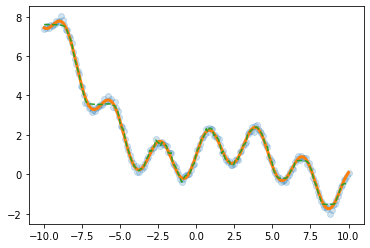

In [63]:
plt.plot(x,y,'o',alpha=0.2)
plt.plot(x,underlying,lw=3)
plt.plot(x,net(x).data,'--')

(예시2)

In [68]:
df=pd.read_csv('https://raw.githubusercontent.com/guebin/DL2022/master/posts/2022-10-04-dnnex0.csv')
df

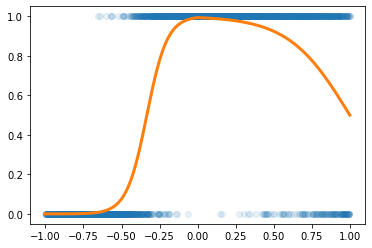

In [69]:
x = torch.tensor(df.x).reshape(-1,1).float()
y = torch.tensor(df.y).reshape(-1,1).float()
plt.plot(x,y,'o',alpha=0.1)
plt.plot(df.x,df.underlying,lw=3)

In [70]:
h = lambda x: torch.sigmoid(200*(x+0.5))+torch.sigmoid(-200*(x-0.5))-1.0
class MyActivation(torch.nn.Module): ## 사용자정의 활성화함수를 선언하는 방법
    def __init__(self):
        super().__init__() 
    def forward(self, input):
        return h(input) 

In [71]:
torch.manual_seed(43052)
net= torch.nn.Sequential(
    torch.nn.Linear(1,2048),
    MyActivation(),
    torch.nn.Linear(2048,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters()) 

In [72]:
for epoc in range(100):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

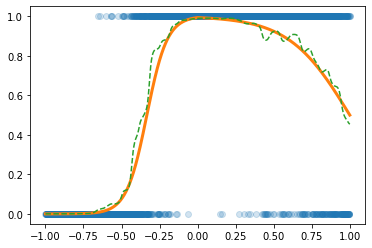

In [73]:
plt.plot(x,y,'o',alpha=0.2)
plt.plot(df.x,df.underlying,lw=3)
plt.plot(x,net(x).data,'--')

# CPU vs GPU

`-` 파이토치에서 GPU를 쓰는 방법을 알아보자. (사실 지금까지 우리는 CPU만
쓰고 있었음)

## GPU 사용방법

`-` cpu 연산이 가능한 메모리에 데이터 저장

In [74]:
torch.manual_seed(43052)
x_cpu = torch.tensor([0.0,0.1,0.2]).reshape(-1,1) 
y_cpu = torch.tensor([0.0,0.2,0.4]).reshape(-1,1) 
net_cpu = torch.nn.Linear(1,1) 

`-` gpu 연산이 가능한 메모리에 데이터 저장

In [75]:
torch.manual_seed(43052)
x_gpu = x_cpu.to("cuda:0")
y_gpu = y_cpu.to("cuda:0")
net_gpu = torch.nn.Linear(1,1).to("cuda:0") 

`-` cpu 혹은 gpu 연산이 가능한 메모리에 저장된 값들을 확인

In [76]:
x_cpu, y_cpu, net_cpu.weight, net_cpu.bias

In [77]:
x_gpu, y_gpu, net_gpu.weight, net_gpu.bias

`-` gpu는 gpu끼리 연산가능하고 cpu는 cpu끼리 연산가능함

(예시1)

In [78]:
net_cpu(x_cpu) 

(예시2)

In [79]:
net_gpu(x_gpu) 

(예시3)

In [80]:
net_cpu(x_gpu) 

(예시4)

In [81]:
net_gpu(x_cpu)

(예시5)

In [82]:
torch.mean((y_cpu-net_cpu(x_cpu))**2)

(예시6)

In [83]:
torch.mean((y_gpu-net_gpu(x_gpu))**2)

(예시7)

In [84]:
torch.mean((y_gpu-net_cpu(x_cpu))**2)

(예시8)

In [85]:
torch.mean((y_cpu-net_gpu(x_gpu))**2)

## 시간측정 (예비학습)

In [86]:
import time 

In [87]:
t1 = time.time()

In [88]:
t2 = time.time()

In [89]:
t2-t1

## CPU (512)

`-` 데이터준비

In [90]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1)
y=torch.randn(100).reshape(-1,1)*0.01

`-` for문 준비

In [91]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,512),
    torch.nn.ReLU(),
    torch.nn.Linear(512,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

`-` for문 + 학습시간측정

In [92]:
t1= time.time()
for epoc in range(1000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

## GPU (512)

`-` 데이터준비

In [93]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1).to("cuda:0")
y=(torch.randn(100).reshape(-1,1)*0.01).to("cuda:0")

`-` for문돌릴준비

In [94]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,512),
    torch.nn.ReLU(),
    torch.nn.Linear(512,1)
).to("cuda:0")
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

`-` for문 + 학습시간측정

In [95]:
t1= time.time()
for epoc in range(1000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

-   !! CPU가 더 빠르다?

## CPU vs GPU (20480)

`-` CPU (20480)

In [96]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1)
y=torch.randn(100).reshape(-1,1)*0.01

net = torch.nn.Sequential(
    torch.nn.Linear(1,20480),
    torch.nn.ReLU(),
    torch.nn.Linear(20480,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

t1= time.time()
for epoc in range(1000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

`-` GPU (20480)

In [97]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1).to("cuda:0")
y=(torch.randn(100).reshape(-1,1)*0.01).to("cuda:0")

net = torch.nn.Sequential(
    torch.nn.Linear(1,20480),
    torch.nn.ReLU(),
    torch.nn.Linear(20480,1)
).to("cuda:0")
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

t1= time.time()
for epoc in range(1000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

`-` 왜 이런 차이가 나는가? 연산을 하는 주체는 코어인데 CPU는 수는 적지만
일을 잘하는 코어들을 가지고 있고 GPU는 일은 못하지만 다수의 코어를
가지고 있기 때문

## CPU vs GPU (204800)

`-` CPU (204800)

In [98]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1)
y=torch.randn(100).reshape(-1,1)*0.01

net = torch.nn.Sequential(
    torch.nn.Linear(1,204800),
    torch.nn.ReLU(),
    torch.nn.Linear(204800,1)
)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

t1= time.time()
for epoc in range(1000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

`-` GPU (204800)

In [99]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(-1,1).to("cuda:0")
y=(torch.randn(100).reshape(-1,1)*0.01).to("cuda:0")

net = torch.nn.Sequential(
    torch.nn.Linear(1,204800),
    torch.nn.ReLU(),
    torch.nn.Linear(204800,1)
).to("cuda:0")
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

t1= time.time()
for epoc in range(1000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1

# 확률적경사하강법, 배치, 에폭

## 좀 이상하지 않아요?

`-` 우리가 쓰는 GPU: [다나와
PC견적](http://shop.danawa.com/virtualestimate/?controller=estimateMain&methods=index&marketPlaceSeq=16)

-   GPU 메모리 끽해봐야 24GB

`-` 우리가 분석하는 데이터: 빅데이터..?

`-` 데이터의 크기가 커지는순간 `X.to("cuda:0")`, `y.to("cuda:0")` 쓰면
난리나겠는걸?

In [100]:
x = torch.linspace(-10,10,100000).reshape(-1,1)
eps = torch.randn(100000).reshape(-1,1)
y = x*2 + eps 

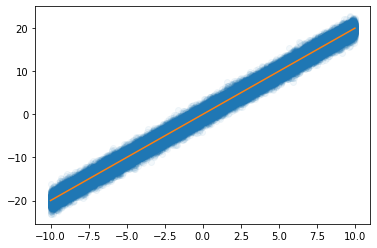

In [101]:
plt.plot(x,y,'o',alpha=0.05)
plt.plot(x,2*x)

`-` 데이터를 100개중에 1개만 꼴로만 쓰면 어떨까?

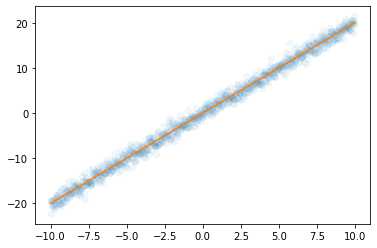

In [102]:
plt.plot(x[::100],y[::100],'o',alpha=0.05)
plt.plot(x,2*x)

-   대충 이거만 가지고 적합해도 충분히 정확할것 같은데

## X,y 데이터를 굳이 모두 GPU에 넘겨야 하는가?

`-` 데이터셋을 짝홀로 나누어서 번갈아가면서 GPU에 올렸다 내렸다하면
안되나?

`-` 아래의 알고리즘을 생각해보자.

1.  데이터를 반으로 나눈다.
2.  짝수obs의 x,y 그리고 net의 모든 파라메터를 GPU에 올린다.
3.  yhat, loss, grad, update 수행
4.  짝수obs의 x,y를 GPU메모리에서 내린다. 그리고 홀수obs의 x,y를
    GPU메모리에 올린다.
5.  yhat, loss, grad, update 수행
6.  홀수obs의 x,y를 GPU메모리에서 내린다. 그리고 짝수obs의 x,y를
    GPU메모리에 올린다.
7.  반복

## 경사하강법, 확률적경사하강법, 미니배치 경사하강법

10개의 샘플이 있다고 가정. $\{(x_i,y_i)\}_{i=1}^{10}$

`-` ver1: 모든 샘플을 이용하여 slope 계산

(epoch1)
$loss=\sum_{i=1}^{10}(y_i-\beta_0-\beta_1x_i)^2 \to slope \to update$

(epoch2)
$loss=\sum_{i=1}^{10}(y_i-\beta_0-\beta_1x_i)^2 \to slope \to update$

…

`-` ver2: 하나의 샘플만을 이용하여 slope 계산

(epoch1) - $loss=(y_1-\beta_0-\beta_1x_1)^2 \to slope \to update$ -
$loss=(y_2-\beta_0-\beta_1x_2)^2 \to slope \to update$ - … -
$loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \to slope \to update$

(epoch2) - $loss=(y_1-\beta_0-\beta_1x_1)^2 \to slope \to update$ -
$loss=(y_2-\beta_0-\beta_1x_2)^2 \to slope \to update$ - … -
$loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \to slope \to update$

…

`-` ver3: $m (\leq n)$ 개의 샘플을 이용하여 slope 계산

$m=3$이라고 하자.

(epoch1) -
$loss=\sum_{i=1}^{3}(y_i-\beta_0-\beta_1x_i)^2 \to slope \to update$ -
$loss=\sum_{i=4}^{6}(y_i-\beta_0-\beta_1x_i)^2 \to slope \to update$ -
$loss=\sum_{i=7}^{9}(y_i-\beta_0-\beta_1x_i)^2 \to slope \to update$ -
$loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \to slope \to update$

(epoch2) -
$loss=\sum_{i=1}^{3}(y_i-\beta_0-\beta_1x_i)^2 \to slope \to update$ -
$loss=\sum_{i=4}^{6}(y_i-\beta_0-\beta_1x_i)^2 \to slope \to update$ -
$loss=\sum_{i=7}^{9}(y_i-\beta_0-\beta_1x_i)^2 \to slope \to update$ -
$loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \to slope \to update$

…

## 용어의 정리

**옛날**

`-` ver1: gradient descent, batch gradient descent

`-` ver2: stochastic gradient descent

`-` ver3: mini-batch gradient descent, mini-batch stochastic gradient
descent

**요즘**

`-` ver1: gradient descent

`-` ver2: stochastic gradient descent with batch size = 1

`-` **ver3: stochastic gradient descent** -
https://www.deeplearningbook.org/contents/optimization.html, 알고리즘
8-1 참고.

## ds, dl

`-` ds

In [103]:
x=torch.tensor(range(10)).float()#.reshape(-1,1)
y=torch.tensor([1.0]*5+[0.0]*5)#.reshape(-1,1)

In [104]:
ds=torch.utils.data.TensorDataset(x,y)
ds

In [105]:
ds.tensors # 그냥 (x,y)의 튜플

`-` dl

In [106]:
dl=torch.utils.data.DataLoader(ds,batch_size=3)
#set(dir(dl)) & {'__iter__'}

In [107]:
for xx,yy in dl:
    print(xx,yy)

tensor([0., 1., 2.]) tensor([1., 1., 1.])
tensor([3., 4., 5.]) tensor([1., 1., 0.])
tensor([6., 7., 8.]) tensor([0., 0., 0.])
tensor([9.]) tensor([0.])

## ds, dl을 이용한 MNIST 구현

`-` 데이터정리

In [108]:
path = untar_data(URLs.MNIST)

In [109]:
zero_fnames = (path/'training/0').ls()
one_fnames = (path/'training/1').ls()

In [110]:
X0 = torch.stack([torchvision.io.read_image(str(zf)) for zf in zero_fnames])
X1 = torch.stack([torchvision.io.read_image(str(of)) for of in one_fnames])
X = torch.concat([X0,X1],axis=0).reshape(-1,1*28*28)/255
y = torch.tensor([0.0]*len(X0) + [1.0]*len(X1)).reshape(-1,1)

In [111]:
X.shape,y.shape

`-` ds $\to$ dl

In [112]:
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size=2048) 

In [113]:
12665/2048

In [114]:
i = 0 
for xx,yy in dl: # 총 7번 돌아가는 for문 
    print(i)
    i=i+1

0
1
2
3
4
5
6

`-` 미니배치 안쓰는 학습

In [115]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())

In [116]:
for epoc in range(70): 
    ## 1 
    yhat = net(X) 
    ## 2 
    loss= loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad() 

In [117]:
torch.sum((yhat>0.5) == y) / len(y) 

`-` 미니배치 쓰는 학습 (GPU 올리고 내리는 과정은 생략)

In [118]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(784,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1),
    torch.nn.Sigmoid()
)
loss_fn = torch.nn.BCELoss()
optimizr = torch.optim.Adam(net.parameters())

In [119]:
for epoc in range(10):
    for xx,yy in dl: ## 7번
        ## 1
        #yhat = net(xx)
        ## 2 
        loss = loss_fn(net(xx),yy) 
        ## 3 
        loss.backward() 
        ## 4 
        optimizr.step()
        optimizr.zero_grad()

In [120]:
torch.mean(((net(X)>0.5) == y)*1.0)

# 오버피팅

`-` 오버피팅이란? - 위키: In mathematical modeling, overfitting is “the
production of an analysis that corresponds too closely or exactly to a
particular set of data, and may therefore fail to fit to additional data
or predict future observations reliably”. - 제 개념: 데이터를 “데이터 =
언더라잉 + 오차”라고 생각할때 우리가 데이터로부터 적합할 것은
언더라잉인데 오차항을 적합하고 있는 현상.

## 오버피팅 예시

`-` $m$이 매우 클때 아래의 네트워크 거의 무엇이든 맞출 수 있다고 보면
된다.

-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{h}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$
-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{sig}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$
-   $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,m)}{\boldsymbol u^{(1)}} \overset{relu}{\to} \underset{(n,m)}{\boldsymbol v^{(1)}} \overset{l_2}{\to} \underset{(n,1)}{\hat{\boldsymbol y}}$

`-` 그런데 종종 맞추지 말아야 할 것들도 맞춘다.

model: $y_i = (0\times x_i) + \epsilon_i$, where
$\epsilon_i \sim N(0,0.01^2)$

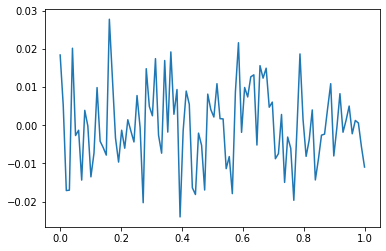

In [121]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(100,1)
y=torch.randn(100).reshape(100,1)*0.01
plt.plot(x,y)

-   y는 그냥 정규분포에서 생성한 오차이므로 $X \to y$ 로 항햐는
    규칙따위는 없음

In [122]:
torch.manual_seed(1) 
net=torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=512,out_features=1)) 
optimizr= torch.optim.Adam(net.parameters())
loss_fn= torch.nn.MSELoss()

for epoc in range(1000): 
    ## 1 
    yhat=net(x) 
    ## 2 
    loss=loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    net.zero_grad() 

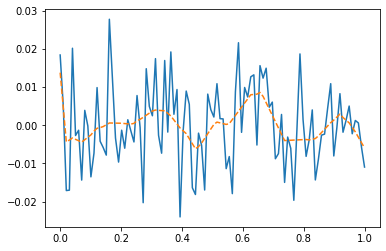

In [123]:
plt.plot(x,y)
plt.plot(x,net(x).data,'--')

-   우리는 데이터를 랜덤에서 뽑았는데, 데이터의 추세를 따라간다 $\to$
    오버피팅 (underlying이 아니라 오차항을 따라가고 있음)

## 오버피팅이라는 뚜렷한 증거! (train / test)

`-` 데이터의 분리하여 보자.

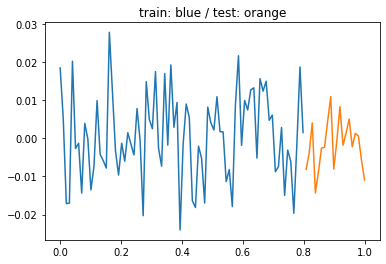

In [124]:
torch.manual_seed(5) 
x=torch.linspace(0,1,100).reshape(100,1)
y=torch.randn(100).reshape(100,1)*0.01
xtr = x[:80] 
ytr = y[:80]
xtest = x[80:]
ytest = y[80:]
plt.plot(xtr,ytr)
plt.plot(xtest,ytest)
plt.title('train: blue / test: orange');

`-` train만 학습

In [125]:
torch.manual_seed(1) 
net=torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=512), 
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=512,out_features=1)) 
optimizr= torch.optim.Adam(net.parameters())
loss_fn= torch.nn.MSELoss()

for epoc in range(1000): 
    ## 1 
    # net(xtr) 
    ## 2 
    loss=loss_fn(net(xtr),ytr) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad() 

`-` training data로 학습한 net를 training data 에 적용

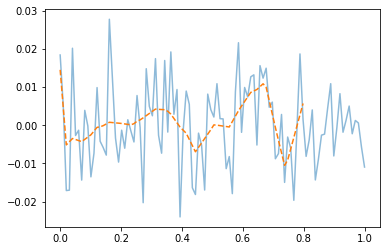

In [126]:
plt.plot(x,y,alpha=0.5)
plt.plot(xtr,net(xtr).data,'--') # prediction (train) 

-   train에서는 잘 맞추는듯이 보인다.

`-` training data로 학습한 net를 test data 에 적용

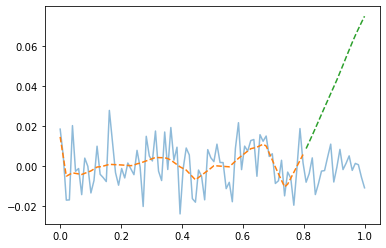

In [127]:
plt.plot(x,y,alpha=0.5)
plt.plot(xtr,net(xtr).data,'--') # prediction (train) 
plt.plot(xtest,net(xtest).data,'--') # prediction with unseen data (test) 

-   train은 그럭저럭 따라가지만 test에서는 엉망이다. $\to$ overfit